In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define path to the data
train_dir =  Path('Skin_dataset_trg')
val_dir = Path('Skin_dataset_val')
test_dir = Path('Skin_dataset_test')

In [3]:
os.listdir(train_dir)

['resized_data_class_1_Melanoma',
 'resized_data_class_2_Nail_Fungus',
 'resized_data_class_4_Viral Infections']

In [4]:
# Loding training dataset in to the pandas DF
def load_train():
    Melanoma_dir=train_dir/'resized_data_class_1_Melanoma'
    Nail_Fungus_dir = train_dir/'resized_data_class_2_Nail_Fungus'
    Viral_Infections_dir = train_dir/'resized_data_class_4_Viral Infections'
    Melanoma = Melanoma_dir.glob('*.jpg')
    Nail_Fungus = Nail_Fungus_dir.glob('*.jpg')
    Viral_Infection = Viral_Infections_dir.glob('*.jpg')
    train_data = []
    train_label = []
    
    for img in Melanoma:
        train_data.append(img)
        train_label.append('Melanoma')
    
    for img in Nail_Fungus:
        train_data.append(img)
        train_label.append('Nail_Fungus')
        
    for img in Viral_Infection:
        train_data.append(img)
        train_label.append('Viral_Infection')
        
    df = pd.DataFrame(train_data)
    df.columns = ['images']
    df['labels']= train_label
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [5]:
train_data = load_train()
train_data.shape
train_data.head()

,images,labels
0,Skin_dataset_trg\resized_data_class_2_Nail_Fun...,Nail_Fungus
1,Skin_dataset_trg\resized_data_class_2_Nail_Fun...,Nail_Fungus
2,Skin_dataset_trg\resized_data_class_4_Viral In...,Viral_Infection
3,Skin_dataset_trg\resized_data_class_1_Melanoma...,Melanoma
4,Skin_dataset_trg\resized_data_class_2_Nail_Fun...,Nail_Fungus


In [6]:
# Validation and Test data as np array
def prepare_and_load(isval=True):
    if isval==True:
        Melanoma_dir=val_dir/'resized_data_class_1_Melanoma'
        Nail_Fungus_dir = val_dir/'resized_data_class_2_Nail_Fungus'
        Viral_Infections_dir = val_dir/'resized_data_class_4_Viral Infections'
        
    else:
        Melanoma_dir=test_dir/'resized_data_class_1_Melanoma'
        Nail_Fungus_dir = test_dir/'resized_data_class_2_Nail_Fungus'
        Viral_Infections_dir = test_dir/'resized_data_class_4_Viral Infections'
        
    Melanoma = Melanoma_dir.glob('*.jpg')
    Nail_Fungus = Nail_Fungus_dir.glob('*.jpg')
    Viral_Infection = Viral_Infections_dir.glob('*.jpg')
    data, labels = ([] for x in range(2))
    def prepare(decease):
        for img in decease:
            img = cv2.imread(str(img))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255
            if decease == Melanoma:
                label = to_categorical(0, num_classes=3)
            elif decease == Nail_Fungus:
                label = to_categorical(1, num_classes=3)
            else:
                label = to_categorical(2, num_classes=3)
            
            data.append(img)
            labels.append(label)
        return data, labels
    prepare(Melanoma)
    prepare(Viral_Infection)
    d, l = prepare(Nail_Fungus)
    d = np.array(d)
    l = np.array(l)
    return d, l

In [7]:
val_data, val_label = prepare_and_load(isval=True)
len(val_data)

684

In [8]:
test_data, test_label = prepare_and_load(isval=False)
len(test_data)

47

In [9]:
# generate images in batches from the train set
def data_gen(data, batch_size):
    n = len(data)
    steps = n//batch_size
    
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size, 3), dtype=np.float32)
    
    indices = np.arange(n)
    
    i=0
    while True:
        np.random.shuffle(indices)

        count =0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            if label== 'Melanoma':
                label=0
            elif label== 'Nail_Fungus':
                label=1
            else:
                label=2
            encoded_label = to_categorical(label, num_classes=3)
            img = cv2.imread(str(img_name))

            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_img = img.astype(np.float32)/255.

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label

            count+=1

            if count==batch_size-1:
                break

        i+=1
        yield batch_data, batch_labels

        if i>=steps:
            i=0

In [10]:
# Model condiguration
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                    

In [25]:
batch_size = 16
nb_epochs = 3

In [26]:
train_data_gen = data_gen(data=train_data, batch_size=batch_size)
nb_train_steps = train_data.shape[0]//batch_size

In [27]:
# adding VGG16 pretained model to obtain better performances
def vgg16_model(num_classes=None):
    model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    
    x = Dense(1024, activation='relu')(model.layers[-4].output)
#     x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
#     x = Dropout(0.3)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(model.input, x)
    
    return model

In [15]:
vgg_conv = vgg16_model(3)
for layer in vgg_conv.layers[: 10]:
    layer.trainable = False

In [29]:
vgg_conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
opt = Adam(lr=0.0001, decay = 1e-5)
vgg_conv.compile(loss= 'binary_crossentropy', metrics= ['accuracy'], optimizer = opt)

C:\Users\laptophut\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
histrory = vgg_conv.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data = (val_data, val_label))

Epoch 1/3
106/106 [==============================] - 1682s 16s/step - loss: 0.3639 - accuracy: 0.6993 - val_loss: 0.3398 - val_accuracy: 0.8450
Epoch 2/3
106/106 [==============================] - 1634s 15s/step - loss: 0.2942 - accuracy: 0.7671 - val_loss: 0.2179 - val_accuracy: 0.8743
Epoch 3/3
106/106 [==============================] - 1640s 16s/step - loss: 0.1842 - accuracy: 0.8278 - val_loss: 0.3392 - val_accuracy: 0.7968


In [18]:
pred = vgg_conv.predict(test_data, batch_size=16)
pred = np.argmax(pred, axis=-1)

3/3 [==============================] - 18s 6s/step


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
labels = np.argmax(test_label, axis=-1)
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       0.84      1.00      0.91        16
           2       1.00      0.38      0.55        16

    accuracy                           0.79        47
   macro avg       0.84      0.79      0.76        47
weighted avg       0.84      0.79      0.76        47



In [21]:
confusion_matrix(labels, pred)

array([[15,  0,  0],
       [ 0, 16,  0],
       [ 7,  3,  6]], dtype=int64)

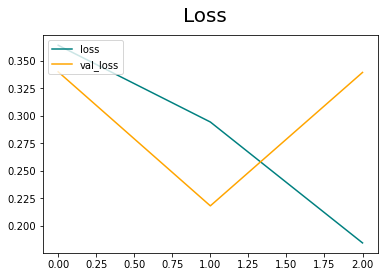

In [22]:
fig = plt.figure()
plt.plot(histrory.history['loss'], color='teal', label='loss')
plt.plot(histrory.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

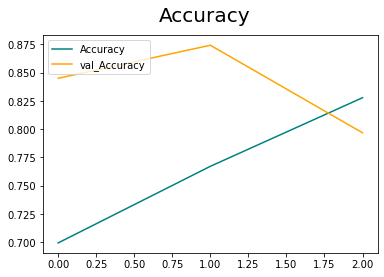

In [23]:
fig = plt.figure()
plt.plot(histrory.history['accuracy'], color='teal', label='Accuracy')
plt.plot(histrory.history['val_accuracy'], color='orange', label='val_Accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [24]:
model.save("model_9.h5")